In [ ]:
import numpy as np
from PIL import Image
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.filters import gaussian_filter

## 1 Load data

The following subsections will load different datasets.
Chose *one* of them to work on.

### 1.1 Week 8 exercise - Classification 2

In [ ]:
datapath = "../week07/"
classnames = ["urban", "forest", "water", "agriculture"]
featurenames = ["img0", "img1", "img2", "img3", "img4", "img5"]

In [ ]:
img = []
N_img = 4
for i in xrange(N_img):
    img.append(np.array(Image.open( \
        datapath + "tm%d.png" % (i+1)), dtype="uint8"))
img = np.array(img)
img_test = np.array(Image.open(datapath + "tm_test.png"), dtype="uint8")
img_train = np.array(Image.open(datapath + "tm_train.png"), dtype="uint8")
N_class = img_train.max()

### 1.2 Mandatory exercise II

In [ ]:
datapath = "../oblig2/features/"
classnames = ["texture 1", "texture 2", "texture 3", "texture 4"]

trainname = "../data/training_mask.p"
maskname = trainname

In [4]:
infile = open("%s%s" % (datapath, trainname), 'r')
img_test = np.array(pickle.load(infile), dtype="uint8")
infile = open("%s%s" % (datapath, trainname), 'r')
img_train = np.array(pickle.load(infile), dtype="uint8")
N_class = img_train.max()

In [1]:
# mosaic 1, training data
filenames = [
    "Q12_mosaic1_train_d01_a000-1_w31.p",
    "Q1_mosaic1_train_d01_a000-1_w31.p",
    "Q2_mosaic1_train_d01_a000-1_w31.p",
]

In [64]:
# mosaic 2, test data
filenames = [
    "Q12_mosaic2_test_d01_a000-1_w31.p",
    "Q1_mosaic2_test_d01_a000-1_w31.p",
    "Q2_mosaic2_test_d01_a000-1_w31.p",]

In [ ]:
featurenames = [
    "Q12_D+1,0", 
    "Q1_D+1,0", 
    "Q2_D+1,0", 
]
N_img = len(filenames)  # Number of features.
img = [None] * N_img
for i, filename in enumerate(filenames):
    infile = open("%s%s" % (datapath, filename), 'r')
    img[i] = np.array(pickle.load(infile), dtype=float)[:,:~0]
img = np.array(img)

##1.3 Simple dummy data

In [ ]:
for i in xrange(N_img):
    img[i][  0:271,   0:271] = 0
    img[i][  0:271, 271:542] = 1
    img[i][271:542,   0:271] = 2
    img[i][271:542, 271:542] = 3
img = img + np.random.uniform(size=img.shape)

## 2 Show data

## 2.1 Feature images and masks

img0   min=       0   mean=0.070081   max=0.183333   nans=0
img1   min=0.0666667   mean= 0.57782   max=       1   nans=0
img2   min=       0   mean=0.0986181   max=    0.25   nans=0


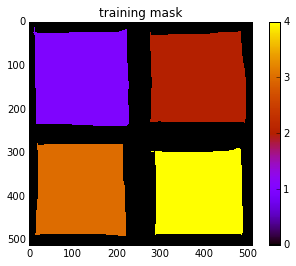

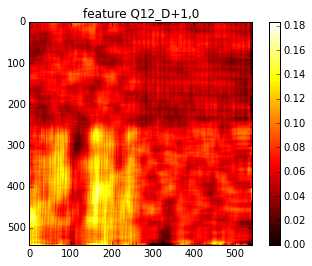

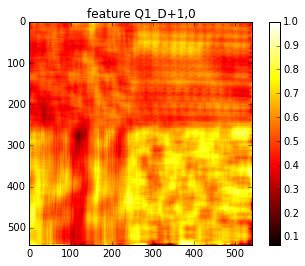

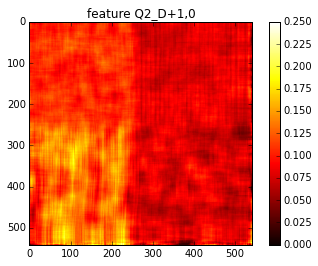

In [56]:
plt.imshow(img_train, interpolation='nearest', cmap='gnuplot')
plt.title("training mask")
plt.colorbar(ticks=range(N_class+1))
#plt.figure()
#plt.imshow(img_test, interpolation='nearest', cmap='gnuplot')
#plt.title("test mask")
for i in xrange(N_img):
    print "img%d   min=%8g   mean=%8g   max=%8g   nans=%d" \
        % ( i, img[i].min(), img[i].mean(), img[i].max(), 
            np.isnan(img[i]).sum()
        )

    plt.figure()
    plt.imshow(
        img[i], 
        #clim=(0, 128), 
        interpolation='nearest', 
        cmap='hot',
    )
    plt.colorbar()
    plt.title("feature %s" % featurenames[i])

## 2.2 Make scatterplots of all feature combinations

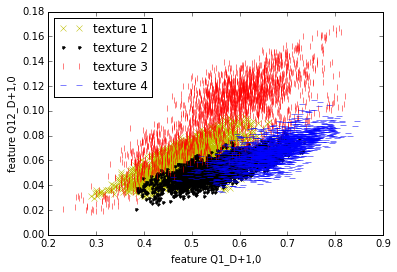

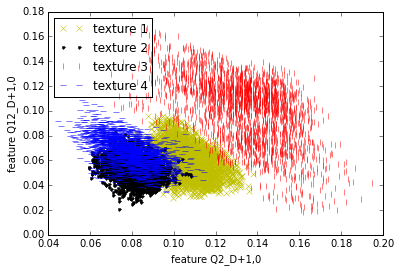

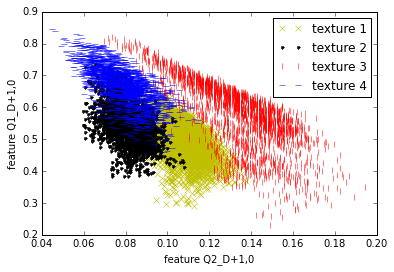

In [57]:
markers = ['x', '.', '|', '_']
colors  = ['y', 'k', 'r', 'b']
for i in xrange(N_img):
    for j in xrange(N_img):
        if j >= i:
            continue
        plt.figure()
        for s in xrange(N_class):
            mask2 = img_train == s+1
            indices2 = np.where(mask2)
            plt.plot(
                img[i][indices2][::16],
                img[j][indices2][::16],
                "%s%s" % (markers[s], colors[s]),
                label="%s" % (classnames[s])
            )
        plt.legend(loc='best')
        plt.xlabel("feature %s" % featurenames[i])
        plt.ylabel("feature %s" % featurenames[j])

# 3 Training

In [7]:
mu = np.zeros((N_class, N_img))
sigma = np.zeros((N_class, N_img, N_img))

for s in xrange(N_class):
    mask = img_train.flatten() == s+1
    indices = np.where(mask)[0]
    mask2 = img_train == s+1
    indices2 = np.where(mask2)
    
    # Find the means:
    for i in xrange(N_img):
        mu[s,i] = np.mean(img[i][indices2])
    
    # Find the covariances:
    sigma[s,:,:] = np.cov(img.reshape(
        N_img, np.prod(img.shape[1:])
    )[:, indices])

print mu.shape
print mu.min(), mu.mean(), mu.max()
print sigma.shape
print sigma.min(), np.abs(sigma).mean(), sigma.max()
print mu
#print np.round(sigma[:]*1000).astype(int)
for s in xrange(N_class):
    print "det =", np.linalg.det(sigma[s])

(4, 3)
0.0246496579553 0.259250638622 0.877956859227
(4, 3, 3)
-0.00519468640211 0.00233414652829 0.0167031941029
[[ 0.05818223  0.43010089  0.09709588]
 [ 0.02464966  0.44063451  0.07037703]
 [ 0.14015198  0.75201844  0.0901343 ]
 [ 0.09328095  0.87795686  0.03642494]]
det = 2.26754723661e-10
det = 1.93695323549e-10
det = 1.22775650393e-09
det = 1.11962990825e-09


# 4 Find probabilities

## 4.1 Compute likelihoods

This is the most import and most demanding computation.

In [73]:
step = 2
likelihood = np.zeros((N_class, img.shape[1], img.shape[2]))
for s in xrange(N_class):
    sig = np.matrix(sigma[s])
    sig_inv = np.linalg.inv(sig)
    denominator = np.sqrt((2 * np.pi)**N_img * np.linalg.det(sig))
    if np.isnan(denominator):
        print "The determinant is negative. Something is wrong."
        break
    for m in xrange(0, img.shape[1], step):
        for n in xrange(0, img.shape[2], step):
            likelihood[s, m:m+step, n:n+step] = np.exp(
                - 0.5 * 
                np.matrix(img[:,m,n] - mu[s]) * sig_inv * 
                np.matrix(img[:,m,n] - mu[s]).transpose()
            ) / denominator 

## 4.2 Compute priors and normalization factors

This is just for scaling of the likelihoods.

In [ ]:
prior = np.zeros(N_class)
prior[:] = 1. / N_class * N_class  # flat prior
normfactor = likelihood.sum(axis=0)

## 4.3 Compute posteriors

Prints the average posterior for each class to show which class is most likely in general, and plots the posterior maps for each class.

In [75]:
posterior = likelihood
posterior = likelihood / normfactor * prior[:,None,None]
posterior[np.where(np.isnan(posterior))] = 1
maxprob = posterior.max()
print "maxprob =", maxprob
print posterior.shape
print posterior.mean()
#print posterior.sum(axis=0)
for s in xrange(N_class):
    print "P(%d|x) = %4.2f" % (s+1, posterior[s].mean())

maxprob = 0.999972040866
(4, 542, 541)
0.25
P(1|x) = 0.25
P(2|x) = 0.24
P(3|x) = 0.24
P(4|x) = 0.26


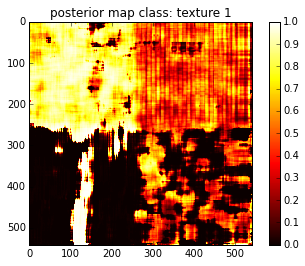

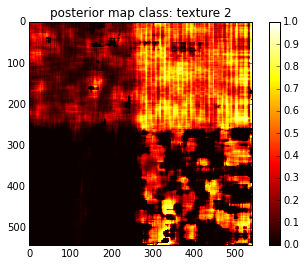

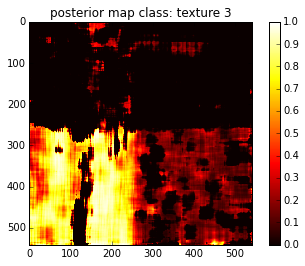

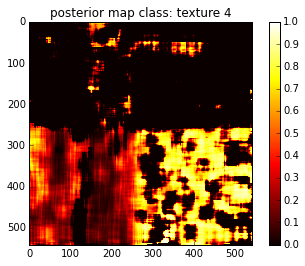

In [61]:
for s in xrange(N_class):
    plt.figure()
    plt.imshow(
        posterior[s], 
        clim=(0, 1), 
        interpolation='nearest', 
        cmap='hot',
    )
    plt.title("posterior map class: %s" % (classnames[s]))
    plt.colorbar()

# 5 Classification

Makes a classification map of the loaded image by classifying each pixels according to which posterior is most likely. Also makes the confusion matrix by counting what each pixel was classified as relative to the given calssification labels in the training mask.

<matplotlib.colorbar.Colorbar instance at 0x7fd37b852d40>

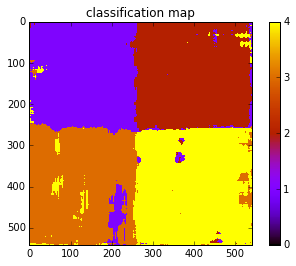

In [76]:
classmap = posterior.argmax(axis=0) + 1
plt.imshow(
    classmap, 
    clim=(0, N_class), 
    interpolation='nearest', 
    cmap='gnuplot',
)
plt.title("classification map")
plt.colorbar(ticks=range(5))

In [77]:
confusion = np.zeros((N_class, N_class), dtype=int)
count_correct = 0
for i in xrange(N_class):  # True class labels
    for j in xrange(N_class):  # Estimated class labels
        count = np.sum(classmap[np.where(img_test == i+1)] == j+1)
        confusion[i,j] = count
        if i == j:
            count_correct += count
            
print "accuracy = %g %%" \
    % (count_correct * 100. / confusion.sum())
print confusion

accuracy = 97.1026 %
[[44550     8    68   244]
 [  196 42761     0   100]
 [ 1881     0 37414  1816]
 [  392    96    16 36711]]
